In [344]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import FloatSlider, interact, Button, VBox, HBox, Output, Layout
from lidar_processing import lidar_processor as LP


In [345]:
def parse_tmca_file(file_path, merged_windows):
    xrf_scans = {}
    ts = 0
    stack_counts = None
    current_window_idx = 0
    x = 0

    with open(file_path, 'r') as file:
        start_x, end_x = merged_windows[current_window_idx][:2]
        ts_min = 0
        ts = 0
        ts_max = np.inf
    
        for line in file:
            line = line.strip()

            if line.startswith("Position:"):
                x = float(line.split("Position:")[1].strip())

                while x < end_x:
                    if stack_counts is not None:
                        ts_max = ts
                        period = ts_max - ts_min
                        stack_counts = stack_counts.astype(float) / period
                        xrf_scans[(start_x, end_x)] = [stack_counts,period]
                        stack_counts = None
                    current_window_idx += 1
                    if current_window_idx >= len(merged_windows):
                        return xrf_scans  
                    start_x, end_x = merged_windows[current_window_idx][:2]

            elif line.startswith("TimeStamp:"):
                
                ts_str = line.split("TimeStamp:")[1].strip()
                time_part = ts_str.split("T")[1].split("-")[0]
                h, m, s = map(float, time_part.split(":"))
                ts = h * 3600 + m * 60 + s
                if stack_counts is None:
                    ts_min = ts

            elif line.startswith("Channels:"):
                channels_str = line.split("Channels:")[1].strip()
                channels = np.array([int(ch) for ch in channels_str.split(",")])
                if stack_counts is None:
                    stack_counts = channels
                else:
                    stack_counts += channels

        if stack_counts is not None and current_window_idx < len(merged_windows):
            ts_max = ts
            period = ts_max - ts_min
            stack_counts = stack_counts.astype(float) / period
            xrf_scans[(start_x, end_x)] = [stack_counts,period]
            stack_counts = None

    return xrf_scans


In [346]:
def xrf_windows_view(file_path, scale_factor=1.0, offset_factor=0.0, merged = False):

    with open(os.path.join(file_path, "rubble_classification.pkl"), 'rb') as file:
        correction_windows = pickle.load(file)


    if merged:
        merged_windows = {}

        corr_keys = sorted(correction_windows.keys(), key=lambda k: k[0])

        def get_sect_type(key):
            vals = correction_windows[key]
            if vals is None:
                return None
            if vals[3] > 0: return 3  # rubble
            if vals[0] > 0: return 0  # half
            if vals[1] > 0: return 1  # full
            if vals[2] > 0: return 2  # empty

        i = 0
        while i < len(corr_keys):
            start_x = corr_keys[i][0]
            current_perc = get_sect_type(corr_keys[i])

            section = []
            j = i
            while j < len(corr_keys):
                next_perc = get_sect_type(corr_keys[j])
                if next_perc != current_perc:
                    break
                section.append(correction_windows[corr_keys[j]])
                j += 1

            end_x = corr_keys[j - 1][1]

            avg_vals = np.mean([vals[4:7] for vals in section], axis=0)

            label_vector = [0, 0, 0, 0]
            label_vector[current_perc] = 1

            merged_windows[(start_x, end_x)] = label_vector + avg_vals.tolist()

            i = j

        correction_windows = merged_windows

    
    corr_keys = [tuple(reversed(k)) for k in sorted(correction_windows.keys(), key=lambda k: k[0], reverse=True)]
    xrf_scans = parse_tmca_file(os.path.join(file_path, "XRAY_DPP_001.tmca"), corr_keys)

    

    
    x_positions = sorted({val for k in xrf_scans for val in (k[0], k[1])})

    saved_profiles = []
    out = Output()
    current_data = [None]

    def plot_profile(x, x_cutoff_max, x_cutoff_min):
        out.clear_output()
        with out:
            type_labels = ["half", "full", "empty", "rubble"]
            plt.figure(figsize=(35, 10), dpi=150)

            for data in saved_profiles:
                plt.plot(data[2], linestyle='--', label=f"XRF Spectrum: {data[1]:.2f} mm to {data[0]:.2f} mm, period={data[3]:.3f}s, type = {data[4]}")

            for start_x, end_x in correction_windows.keys():
                if start_x <= x <= end_x:
                    channels, ts = xrf_scans[(end_x, start_x)]
                    if channels is not None:
                        label = correction_windows[start_x, end_x][:4]
                        label = np.argmax(label)
                        
                        plt.title(f"XRF Spectrum: {start_x:.2f} mm to {end_x:.2f} mm, period={ts:.3f}s, type = {type_labels[label]}", fontsize=20)
                        plt.plot(channels, label=f"XRF Spectrum: {start_x:.2f} mm to {end_x:.2f} mm, period={ts:.3f}s, type = {type_labels[label]}")
                        current_data = [start_x, end_x, channels, ts, type_labels[label]]
                    break

            ticks = np.arange(x_cutoff_min, x_cutoff_max, (x_cutoff_max - x_cutoff_min)/200)
            plt.xticks(
                ticks=ticks,
                labels=[f"{tick * scale_factor + offset_factor:.2f}" for tick in ticks],
                rotation=70
            )

            plt.xlim(x_cutoff_min, x_cutoff_max)
            plt.xlabel('kEv')
            plt.ylabel('Intensity')
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.show()

            for start_x, end_x in correction_windows.keys():
                if start_x <= x <= end_x:
                    values = correction_windows[start_x, end_x]
                    print(f"Correction values from {start_x:.2f} mm to {end_x:.2f} mm:")
                    labels = ["half_perc", "full_perc", "empty_perc", "rubble_perc", "var", "x_ang", "y_ang"]
                    for label, val in zip(labels, values):
                        print(f"  {label} = {val}")
                    break

    def save_current_plot(_):
        if current_data[0] is not None:
            saved_profiles.append(current_data[0].copy())
            plot_profile(slider.value, cutoff_slider_max.value, cutoff_slider_min.value)

    slider = FloatSlider(
        min=min(x_positions),
        max=max(x_positions),
        step=0.01,
        continuous_update=False,
        layout=Layout(width='1750px')
    )

    cutoff_slider_max = FloatSlider(
        min=0,
        max=2048,
        step=1,
        continuous_update=False,
        value=2048,
        description="X Cutoff (channels)",
        layout=Layout(width='500px')
    )

    cutoff_slider_min = FloatSlider(
        min=0,
        max=2048,
        step=1,
        continuous_update=False,
        value=0,
        description="X Cutoff (channels)",
        layout=Layout(width='500px')
    )

    save_button = Button(description="Save Current Spectrum")
    save_button.on_click(save_current_plot)

    interact(plot_profile, x=slider, x_cutoff_max=cutoff_slider_max, x_cutoff_min=cutoff_slider_min)
    display(HBox([save_button]), out)

c:\Users\eashenhurst\Python\test\LP_env\lib\site-packages\lidar_processing\lidar_processing.py:369: RuntimeWarning: divide by zero encountered in log
  array_i = cp.array(np.log(np.abs(self.intensity_cloud)), dtype=cp.float32)


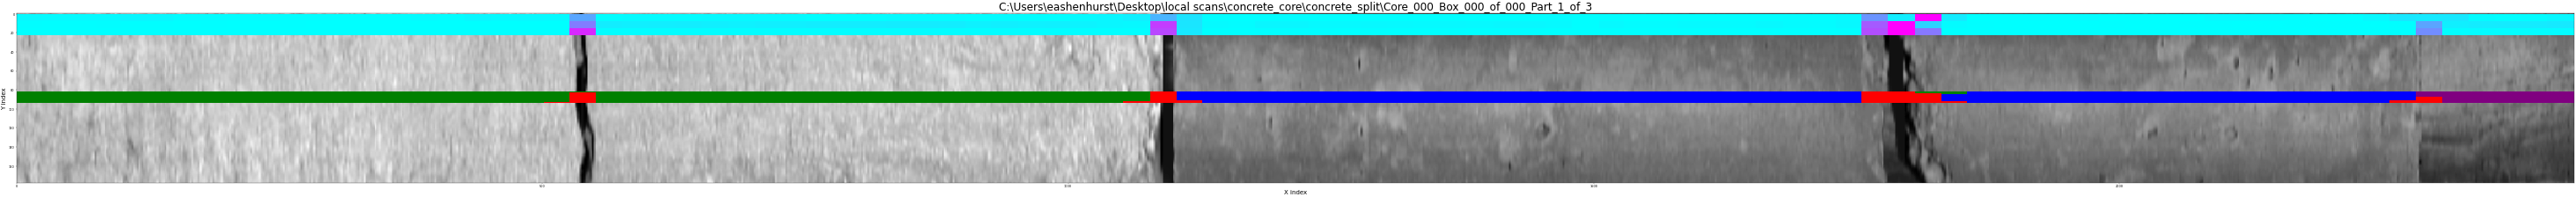

interactive(children=(FloatSlider(value=760.72523828125, continuous_update=False, description='x', layout=Layo…

Output()

interactive(children=(FloatSlider(value=760.72523828125, continuous_update=False, description='x', layout=Layo…

Output()

In [347]:
sf = 0.0161
of = 0.12

path = r"C:\Users\eashenhurst\Desktop\local scans\concrete_core\concrete_split\Core_000_Box_000_of_000_Part_1_of_3"
#LP(path, window_size = 15, noise_threshold=0.25)._save_correction_windows(xrf_window_size = 10, height = 10, dpi = 25)
LP(path, window_size = 15, noise_threshold=0.25)._plot_correction_windows(xrf_window_size = 10, height = 10, dpi = 25)
xrf_windows_view(path, sf, of, merged = True)
xrf_windows_view(path, sf, of, merged = False)

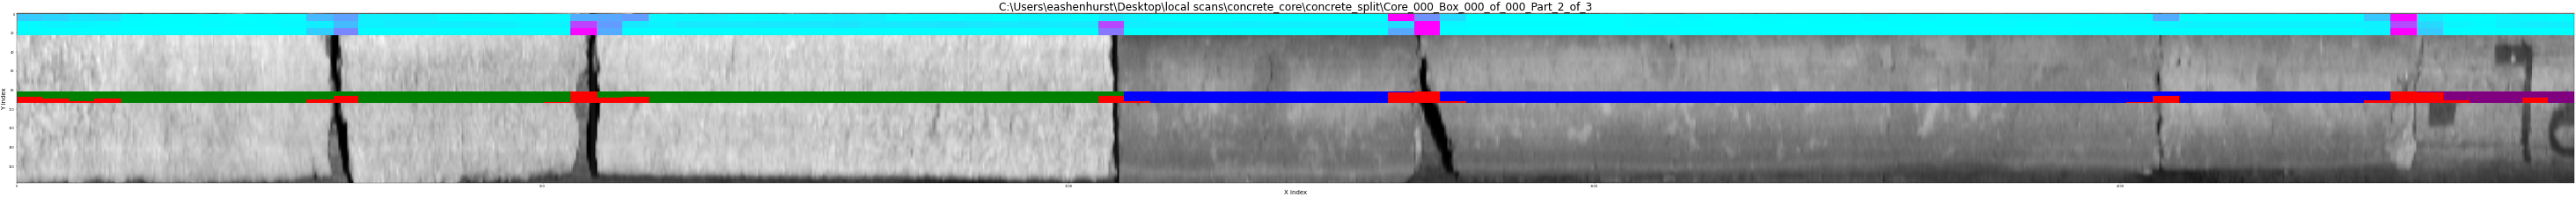

interactive(children=(FloatSlider(value=760.7680849609375, continuous_update=False, description='x', layout=La…

Output()

interactive(children=(FloatSlider(value=760.7680849609375, continuous_update=False, description='x', layout=La…

Output()

In [348]:

path = r"C:\Users\eashenhurst\Desktop\local scans\concrete_core\concrete_split\Core_000_Box_000_of_000_Part_2_of_3"

#LP(path, window_size = 15, noise_threshold=0.25)._save_correction_windows(xrf_window_size = 10, height = 10, dpi = 25)
LP(path, window_size = 15, noise_threshold=0.25)._plot_correction_windows(xrf_window_size = 10, height = 10, dpi = 25)
xrf_windows_view(path, sf, of, merged = True)
xrf_windows_view(path, sf, of, merged = False)


c:\Users\eashenhurst\Python\test\LP_env\lib\site-packages\lidar_processing\lidar_processing.py:369: RuntimeWarning: divide by zero encountered in log
  array_i = cp.array(np.log(np.abs(self.intensity_cloud)), dtype=cp.float32)


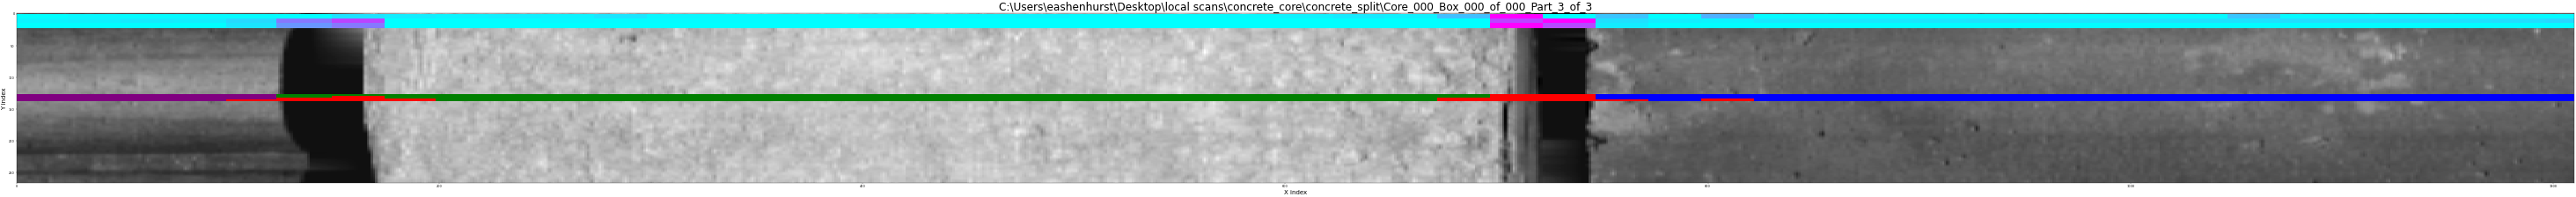

interactive(children=(FloatSlider(value=1750.750384765625, continuous_update=False, description='x', layout=La…

Output()

interactive(children=(FloatSlider(value=1750.750384765625, continuous_update=False, description='x', layout=La…

Output()

In [349]:
path = r"C:\Users\eashenhurst\Desktop\local scans\concrete_core\concrete_split\Core_000_Box_000_of_000_Part_3_of_3"

#LP(path, window_size = 25, noise_threshold=0.25)._save_correction_windows(xrf_window_size = 10, height = 10, dpi = 25)
LP(path, window_size = 25, noise_threshold=0.25)._plot_correction_windows(xrf_window_size = 10, height = 10, dpi = 25)
xrf_windows_view(path, sf, of, merged = True)
xrf_windows_view(path, sf, of, merged = False)


c:\Users\eashenhurst\Python\test\LP_env\lib\site-packages\lidar_processing\lidar_processing.py:369: RuntimeWarning: divide by zero encountered in log
  array_i = cp.array(np.log(np.abs(self.intensity_cloud)), dtype=cp.float32)


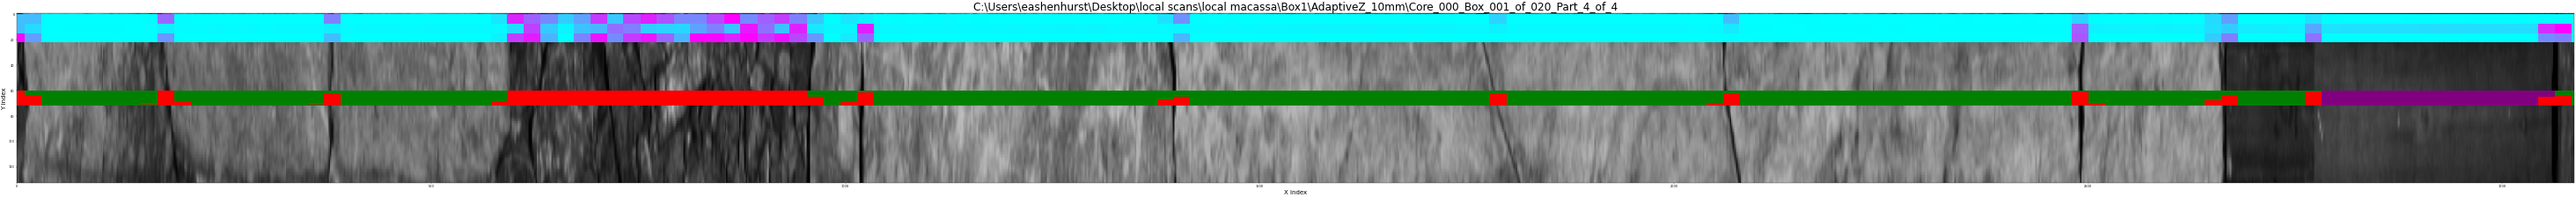

interactive(children=(FloatSlider(value=604.7898044433593, continuous_update=False, description='x', layout=La…

Output()

interactive(children=(FloatSlider(value=604.7898044433593, continuous_update=False, description='x', layout=La…

Output()

In [350]:
path = r"C:\Users\eashenhurst\Desktop\local scans\local macassa\Box1\AdaptiveZ_10mm\Core_000_Box_001_of_020_Part_4_of_4"

#LP(path, window_size = 10, noise_threshold=0.25)._save_correction_windows(xrf_window_size = 10, height = 10, dpi = 25)
LP(path, window_size = 10, noise_threshold=0.25)._plot_correction_windows(xrf_window_size = 10, height = 10, dpi = 25)
xrf_windows_view(path, sf, of, merged = True)
xrf_windows_view(path, sf, of, merged = False)


In [351]:
stop 
#run if you need to create correction window pickles
root_dir = r"C:\Users\eashenhurst\Desktop\local scans\local macassa"
filter = "5mm"

paths_list = []
for root, dirs, files in os.walk(root_dir):
        for dir_name in dirs:
                folder = os.path.join(root,dir_name)
                if filter in folder:
                    paths_list.append(folder)
i = 10 
for folder in paths_list:
        try:
            processor = LP(folder, window_size = i,noise_threshold=0.25)
        except FileNotFoundError as e:
            print(f"   Error: {e}")
        else:
            processor._save_correction_windows(xrf_window_size = 10)
            print(f"{processor.name} finished")

NameError: name 'stop' is not defined